<a href="https://colab.research.google.com/github/kridtapon/MFI-HMA-Alpha/blob/main/MFI_HMA_Alpha.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.4/527.4 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 63.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 72.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.6/34.6 MB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 49.1 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.43.0
    Uninstalling llvmlite-0.43.0:
      Successfully uninstalled llvmlite-0.43.0
  Attempting uninstall: numba
    Found existing installation: numba 0.60.0
    Uninstalling numba-0.60.0:
      Successfully uninst

[*********************100%***********************]  1 of 1 completed


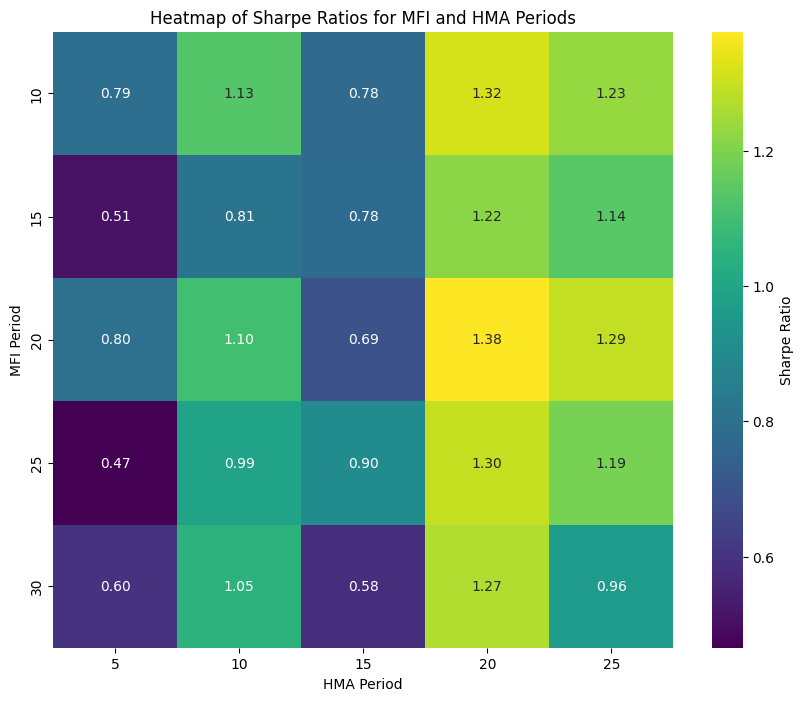

Best MFI period: 20, Best HMA period: 20
Start                                2019-01-01 00:00:00
End                                  2024-12-21 00:00:00
Period                                2182 days 00:00:00
Start Value                                     100000.0
End Value                                 4361254.708459
Total Return [%]                             4261.254708
Benchmark Return [%]                         2269.859637
Max Gross Exposure [%]                             100.0
Total Fees Paid                            274687.616904
Max Drawdown [%]                               57.418419
Max Drawdown Duration                  843 days 00:00:00
Total Trades                                          78
Total Closed Trades                                   78
Total Open Trades                                      0
Open Trade PnL                                       0.0
Win Rate [%]                                        50.0
Best Trade [%]                                 

In [8]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt
import seaborn as sns
import matplotlib.pyplot as plt

def calculate_mfi(df, period=14):
    """Calculate Money Flow Index (MFI)."""
    typical_price = (df['High'] + df['Low'] + df['Close']) / 3
    money_flow = typical_price * df['Volume']
    positive_flow = money_flow.where(typical_price > typical_price.shift(1), 0)
    negative_flow = money_flow.where(typical_price < typical_price.shift(1), 0)

    positive_flow_sum = positive_flow.rolling(window=period).sum()
    negative_flow_sum = negative_flow.rolling(window=period).sum()

    mfi = 100 * (positive_flow_sum / (positive_flow_sum + negative_flow_sum))
    return mfi

def calculate_hma(df, period=14):
    """Calculate Hull Moving Average (HMA)."""
    half_length = period // 2
    sqrt_length = int(np.sqrt(period))

    wma_half = df['Close'].rolling(window=half_length).mean()
    wma_full = df['Close'].rolling(window=period).mean()

    hma = (2 * wma_half - wma_full).rolling(window=sqrt_length).mean()
    return hma

# Define the stock symbol and time period
symbol = 'ETH-USD'
start_date = '2019-01-01'
end_date = '2024-12-23'

# Download the data
df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
df.ffill(inplace=True)

# Define parameter ranges for optimization
mfi_periods = [10, 15, 20, 25, 30]
hma_periods = [5, 10, 15, 20, 25]

sharpe_matrix = pd.DataFrame(index=mfi_periods, columns=hma_periods)

# Loop through different parameter combinations
for mfi_period in mfi_periods:
    for hma_period in hma_periods:
        # Calculate MFI and HMA for the current parameters
        df['MFI'] = calculate_mfi(df, period=mfi_period)
        df['HMA'] = calculate_hma(df, period=hma_period)

        # Define entry and exit signals
        df['Entry'] = (
            (df['MFI'] < 80) &
            (df['MFI'] > df['MFI'].shift(1)) &
            (df['HMA'] > df['HMA'].shift(1))
        )
        df['Exit'] = (
            (df['MFI'] > 20) &
            (df['MFI'] < df['MFI'].shift(1)) &
            (df['HMA'] < df['HMA'].shift(1))
        )

        # Convert signals to boolean arrays
        entries = df['Entry'].to_numpy()
        exits = df['Exit'].to_numpy()

        # Backtest using vectorbt
        portfolio = vbt.Portfolio.from_signals(
            close=df['Close'],
            entries=entries,
            exits=exits,
            init_cash=100_000,
            fees=0.001
        )

        # Get Sharpe ratio for the current parameter combination
        sharpe_ratio = portfolio.stats()['Sharpe Ratio']

        # Store the Sharpe ratio in the matrix
        sharpe_matrix.loc[mfi_period, hma_period] = sharpe_ratio

# Convert matrix values to numeric
sharpe_matrix = sharpe_matrix.astype(float)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(sharpe_matrix, annot=True, fmt=".2f", cmap="viridis", cbar_kws={'label': 'Sharpe Ratio'})
plt.title("Heatmap of Sharpe Ratios for MFI and HMA Periods")
plt.xlabel("HMA Period")
plt.ylabel("MFI Period")
plt.show()

# Find the best parameters based on the highest Sharpe ratio
best_mfi_period, best_hma_period = sharpe_matrix.idxmax(axis=1).iloc[0], sharpe_matrix.idxmax(axis=0).iloc[0]
print(f"Best MFI period: {best_mfi_period}, Best HMA period: {best_hma_period}")

# Calculate MFI (Money Flow Index) and HMA (Hull Moving Average) with the best parameters
df['MFI'] = calculate_mfi(df, period=best_mfi_period)
df['HMA'] = calculate_hma(df, period=best_hma_period)

# Define entry signal
df['Entry'] = (
    (df['MFI'] < 80) &  # MFI below 80
    (df['MFI'] > df['MFI'].shift(1)) &  # MFI rising
    (df['HMA'] > df['HMA'].shift(1))
)

# Define exit signal
df['Exit'] = (
    (df['MFI'] > 20) &  # MFI above 20
    (df['MFI'] < df['MFI'].shift(1)) &
    (df['HMA'] < df['HMA'].shift(1))
)

# Convert signals to boolean arrays
entries = df['Entry'].to_numpy()
exits = df['Exit'].to_numpy()

# Backtest using vectorbt
portfolio = vbt.Portfolio.from_signals(
    close=df['Close'],
    entries=entries,
    exits=exits,
    init_cash=100_000,
    fees=0.001
)

# Display performance metrics
print(portfolio.stats())

# Plot equity curve
portfolio.plot().show()
